# Genetic Algorithm

In [1]:
import time
import random
import math
from sklearn.metrics import accuracy_score

#Retorna o tamanho do estado
def Get_State_Size(state):
    size = 0
    for nr_Selected in state:
        if nr_Selected == 1:
            size += 1

    return size

#Retorna a classificassao mais frequente da base
def Get_Most_Frequent(column, baseFrequencies):
        frequencies = cl.Counter(column).items()
        betterFrequency = 0
        better = None
        
        for key, value in frequencies:
            if(value > betterFrequency):
                better = key
                betterFrequency = value
            elif(value == betterFrequency):
                for selfKey, selfValue in baseFrequencies.most_common():
                    if(selfKey == better):
                        break
                    if(selfKey == key):
                        better = key
                        betterFrequency = value
        return better

#valida os resultados dos classificadores
def Evaluate_State(state, classifiers, data, target):
    classifiersList = []
    predictions = []
    result = []

    if(state == []):
      return 0
    
    for nr_Index, b_Using in enumerate(state):
        if b_Using == 1:
            classifiersList.append(classifiers[nr_Index])

    for classifier in classifiersList:
        prediction = classifier.predict(data)
        predictions.append(prediction)


    dataFrame = pd.DataFrame(data=predictions)

    frequencies = cl.Counter(target)  

    for index in dataFrame.columns:
        column = dataFrame[index]
        choice = Get_Most_Frequent(column, frequencies)
        result.append(choice)

    return accuracy_score(target, result)

#Retorna os valores da populacao
def Evaluate_Population (pop, classifiers, data, target):
    eval = []
    for s in pop:
        eval = eval + [(Evaluate_State(s, classifiers, data, target), s)]
    return eval   

#Retorna o valor total dos estados
def Get_States_Total_Value(states):
    total_sum = 0
    for state in states:
        total_sum = total_sum + state[0]
    return total_sum

#Funcao que constroi da roleta
def Roulette_Construction(states):
    aux_states = []
    roulette = []
    total_value = Get_States_Total_Value(states)

    for state in states:
        value = state[0]
        if total_value != 0:
            ratio = value/total_value
        else:
            ratio = 1
        aux_states.append((ratio,state[1]))
 
    acc_value = 0
    for state in aux_states:
        acc_value = acc_value + state[0]
        s = (acc_value,state[1])
        roulette.append(s)
    return roulette

#Funcao da roleta
def Roulette_Run (rounds, roulette):
    if roulette == []:
        return []
    selected = []
    while len(selected) < rounds:
        r = random.uniform(0,1)
        for state in roulette:
            if r <= state[0]:
                selected.append(state[1])
                break
    return selected

#Gera os estados iniciais
def Generate_Initial_State(classifiers):
    initial_state = []
    zero_state = [0] * len(classifiers)
    for i in range(len(classifiers)):
        initial_state.append(random.randint(0,1))

    if np.array_equal(zero_state, initial_state):
      initial_state = Generate_Initial_State(classifiers)

    return initial_state

def First(x):
    return x[0]

#Retorna os novos estados
def Get_Selection(value_population,n):
    aux_population = Roulette_Construction(value_population)
    new_population = Roulette_Run(n, aux_population)
    return new_population

#Faz o crossover
def Get_Crossover(dad,mom):
    r = random.randint(0, len(dad) - 1)
    son = dad[:r]+mom[r:]
    daug = mom[:r]+dad[r:]
    return son, daug

#Retorna a mutacao
def Get_Mutation (indiv):
    individual = indiv.copy()
    rand = random.randint(0, len(individual) - 1)
    if individual[rand] > 0:
        r = random.uniform(0,1)
        if r > 0.5:
            individual[rand] = 1
        else:
            individual[rand] = 0
    else:
        individual[rand] = 1
        
    return individual

#Gera a populacao inciial
def Get_Initial_Population(n, classifiers):
    pop = []
    count = 0
    while count < n:
        individual = Generate_Initial_State(classifiers)
        pop = pop + [individual]
        count += 1
    return pop

#Faz a convergencia da populacao
def Get_Convergent(population):
    conv = False
    if population != []:
        base = population[0]
        i = 0
        while i < len(population):
            if base != population[i]:
                return False
            i += 1
        return True

#Retorna as classes atraves do elitismo
def Get_Elitism (val_pop, pct):
    n = math.floor((pct/100)*len(val_pop))
    if n < 1:
        n = 1
    val_elite = sorted (val_pop, key = First, reverse = True)[:n]
    elite = [s for v,s in val_elite]
    return elite

#Funcao que retorna o crossover
def Get_Crossover_Step (population, crossover_ratio):
    new_pop = []
    
    for _ in range (round(len(population)/2)):
        rand = random.uniform(0, 1)
        fst_ind = random.randint(0, len(population) - 1)
        scd_ind = random.randint(0, len(population) - 1)
        parent1 = population[fst_ind] 
        parent2 = population[scd_ind]

        if rand <= crossover_ratio:
            offspring1, offspring2 = Get_Crossover(parent1, parent2)            
            
            if Get_State_Size(offspring1) == 0:
                offspring1 = parent1
            if Get_State_Size(offspring2) == 0:
                offspring2 = parent2
        else:
            offspring1, offspring2 = parent1, parent2
                
        new_pop = new_pop + [offspring1, offspring2]
        
    return new_pop

#Faz a mutacao
def Get_Mutation_Step (population, mutation_ratio):
    ind = 0
    for individual in population:
        rand = random.uniform(0, 1)

        if rand <= mutation_ratio:
            mutated = Get_Mutation(individual)
            if Get_State_Size(mutated) > 0:
              population[ind] = mutated
                
        ind+=1
        
    return population   

#Parte principal do algoritmo
def Genetic (classifiers, data, target, pop_size, max_iter, cross_ratio, mut_ratio, max_time, elite_pct):
    start = time.process_time()
    opt_state = [0] * len(classifiers)
    opt_value = 0
    pop = Get_Initial_Population(pop_size, classifiers)
    conv = Get_Convergent(pop)
    iter = 0    
    end = 0

    while not conv and iter < max_iter and end-start <= max_time:
        val_pop = Evaluate_Population (pop, classifiers, data, target)
        new_pop = Get_Elitism (val_pop, elite_pct)
        best = new_pop[0]
        val_best = Evaluate_State(best, classifiers, data, target)

        if (val_best > opt_value):
            opt_state = best
            opt_value = val_best

        selected = Get_Selection(val_pop, pop_size - len(new_pop)) 
        crossed = Get_Crossover_Step(selected, cross_ratio)
        mutated = Get_Mutation_Step(crossed, mut_ratio)
        pop = new_pop + mutated
        conv = Get_Convergent(pop)
        iter+=1
        end = time.process_time()
        
  
    return opt_state

# Simulated Annealing

In [14]:
import time
import random
import math
from sklearn.metrics import accuracy_score

#Retorna a classificassao mais frequente da base
def Get_Most_Frequent(column, baseFrequencies):
        frequencies = cl.Counter(column).items()
        betterFrequency = 0
        better = None
        
        for key, value in frequencies:
            if(value > betterFrequency):
                better = key
                betterFrequency = value
            elif(value == betterFrequency):
                for selfKey, selfValue in baseFrequencies.most_common():
                    if(selfKey == better):
                        break
                    if(selfKey == key):
                        better = key
                        betterFrequency = value
        return better

#FAz o estado inicial atraves de randomizacao
def Generate_Initial_State(classifiers):
    initial_state = []
    zero_state = [0] * len(classifiers)
    for i in range(len(classifiers)):
        initial_state.append(random.randint(0,1))

    if np.array_equal(zero_state, initial_state):
      initial_state = Generate_Initial_State(classifiers)

    return initial_state

#Retorna o tamanho do estado
def Get_State_Size(state):
    size = 0
    for nr_Selected in state:
        if nr_Selected == 1:
            size += 1

    return size

#valida os resultados dos classificadores
def Evaluate_State(state, classifiers, data, target):
    classifiersList = []
    predictions = []
    result = []

    if(state == []):
      return 0
    
    for nr_Index, b_Using in enumerate(state):
        if b_Using == 1:
            classifiersList.append(classifiers[nr_Index])

    for classifier in classifiersList:
        prediction = classifier.predict(data)
        predictions.append(prediction)


    dataFrame = pd.DataFrame(data=predictions)

    frequencies = cl.Counter(target)  

    for index in dataFrame.columns:
        column = dataFrame[index]
        choice = Get_Most_Frequent(column, frequencies)
        result.append(choice)

    return accuracy_score(target, result)

#Retorna o valor total dos estados
def States_Total_Value(states):
    total_sum = 0
    for state in states:
        total_sum = total_sum + state[0]
    return total_sum

#Retorna um estado aleatorio
def Random_State(states):
    index = random.randint(0,len(states)-1)
    return states[index]

#Modifica um estado selecionado
def Change_State(state,position,value):
    state[position] = value
    return state

#Gera os estados vizinhos
def Generate_Neighborhood(state):
    neighborhood = []
    zero_state = [0]*len(state)

    for i in range(len(state)):
        aux = state.copy()
        new_state = Change_State(aux,i,1)
        if not np.array_equal(state, new_state):
          neighborhood.append(new_state)
    for i in range(len(state)):
        aux = state.copy()
        new_state = Change_State(aux,i,0)
        if not np.array_equal(state, new_state):
          if not np.array_equal(zero_state, new_state):
             neighborhood.append(new_state)

    return neighborhood

#Verifica a probabilidade
def Change_Probability(value,best_value,t):
    p = 1/(math.exp(1)**((best_value-value)/t))
    r = random.uniform(0,1)
    if r < p:
        return True
    else:
        return False

#Funcao principal do simulated annealing
def Simulated_Annealing(t,alfa,classifiers,data, target,iter_max,max_time):
    state = Generate_Initial_State(classifiers)
    solution = state
    max_value = Evaluate_State(solution, classifiers, data, target)
    start = time.process_time()
    end = 0
    
    while t >= 1 and end-start <= max_time:        
        
        for _ in range(iter_max):    
            neighborhood = Generate_Neighborhood(state)
            if neighborhood == []:
                return solution,max_value,Get_State_Size(solution)                
            aux = Random_State(neighborhood)
            aux_value = Evaluate_State(aux, classifiers, data, target)
            aux_size = Get_State_Size(aux)
            state_value = Evaluate_State(state, classifiers, data, target)
            if aux_value > state_value:
                state = aux
                if aux_value > max_value:
                    solution = aux
                    max_value = aux_value
            else:
                if Change_Probability(aux_value,state_value,t):
                    state = aux
        t = t*alfa
        end = time.process_time()

    return solution

# Hill Climbing

In [15]:
import time
from sklearn.metrics import accuracy_score

#Retorna a classificassao mais frequente da base
def Get_Most_Frequent(column, baseFrequencies):
        frequencies = cl.Counter(column).items()
        betterFrequency = 0
        better = None
        
        for key, value in frequencies:
            if(value > betterFrequency):
                better = key
                betterFrequency = value
            elif(value == betterFrequency):
                for selfKey, selfValue in baseFrequencies.most_common():
                    if(selfKey == better):
                        break
                    if(selfKey == key):
                        better = key
                        betterFrequency = value
        return better

#Retorna o tamanho do estado
def Get_State_Size(state):
    size = 0
    for nr_Selected in state:
        if nr_Selected == 1:
            size += 1

    return size

#valida os resultados dos classificadores
def Evaluate_State(state, classifiers, data, target):
    classifiersList = []
    predictions = []
    result = []
    
    for nr_Index, b_Using in enumerate(state):
        if b_Using == 1:
            classifiersList.append(classifiers[nr_Index])

    for classifier in classifiersList:
        prediction = classifier.predict(data)
        predictions.append(prediction)


    dataFrame = pd.DataFrame(data=predictions)

    frequencies = cl.Counter(target)  

    for index in dataFrame.columns:
        column = dataFrame[index]
        choice = Get_Most_Frequent(column, frequencies)
        result.append(choice)

    return accuracy_score(target, result)

#Gera todos os estados permitidos
def Generate_States(initial_state):
    states = []
    for i in range(len(initial_state)):
        aux = initial_state.copy()
        aux[i] = initial_state[i] + 1
        if(aux[i] < 2):
            states.append(aux)
    return states


#Classe principal do Hill Climbing
def Hill_Climbing(classifiers, data, target, max_time):
    start = time.process_time()
    current_state = [0]*len(classifiers)
    optimal_value = 0
    optimal_size = 0
    optimal_state = current_state
    valid_states = len(classifiers)
    end = 0
    
    while end-start <= max_time and valid_states != 0:
        possible_states = Generate_States(optimal_state)
        valid_states = len(possible_states)
        last_value = optimal_value

        for state in possible_states:
            aux_value = Evaluate_State(state, classifiers, data, target)
            aux_size = Get_State_Size(state)
            if aux_size != 0:
                if aux_value >= optimal_value:
                    optimal_value = aux_value
                    optimal_size = aux_size
                    optimal_state = state
                else:
                    valid_states = valid_states - 1
            
        end = time.process_time()

    return optimal_state


# Classificador Heterogeneous Pooling

In [16]:
from sklearn.base import BaseEstimator
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample
import pandas as pd
import collections as cl
import numpy as np

#Classe de Heterogenous Pooling
class HPClassifier(BaseEstimator):
    def __init__(self, n_Samples=None, nm_Metaheuristic="HillClimbing"):
        super().__init__()
        self.n_Samples = n_Samples
        self.classifiers = []
        self.frequencies = []
        self.nm_Metaheuristic = nm_Metaheuristic

    def fit(self, data, target):
        classifiers = []
        
        self.frequencies = cl.Counter(target)

        #Gera os resample
        for nr_Index in range(self.n_Samples):
            dataAux, targetAux = resample(data, target, random_state=nr_Index)

            gaussianClassifier = GaussianNB()
            decisionClassifier = DecisionTreeClassifier()
            knnClassifier = KNeighborsClassifier(n_neighbors=1)

            gaussianClassifier.fit(dataAux, targetAux)
            decisionClassifier.fit(dataAux, targetAux)
            knnClassifier.fit(dataAux, targetAux)

            classifiers.append(gaussianClassifier)
            classifiers.append(decisionClassifier)
            classifiers.append(knnClassifier)
        
        optimal_state =  []

        #Verifica a metaheuristica selecionada
        if(self.nm_Metaheuristic == "HillClimbing"):
          optimal_state  = Hill_Climbing(classifiers, data, target, 120)
        elif(self.nm_Metaheuristic == "SimulatedAnnealing"):
          optimal_state = Simulated_Annealing(200, 0.1, classifiers, data, target,10, 120)
        else:
          optimal_state = Genetic(classifiers, data, target, 20, 100, 0.9, 0.1, 120, 20)
          
        print(optimal_state, "optimal")

        #Lista de classificadores
        classifiersList = []
        for nr_Index, classifier in enumerate(classifiers):
            if optimal_state[nr_Index] == 1:
                classifiersList.append(classifier)
        
        self.classifiers = classifiersList

    def predict(self, data):
        result = []
        predictions = []

        for classifier in self.classifiers:
            prediction = classifier.predict(data)
            predictions.append(prediction)

        dataFrame = pd.DataFrame(data=predictions)
        data = np.asarray(data)

        for index in dataFrame.columns:
            column = dataFrame[index]
            
            choice = self.getBetterChoice(column)
            result.append(choice)

        return np.asarray(result)

    #Retorna o valor mais frequente da base
    def getBetterChoice(self, column):
        frequencies = cl.Counter(column).items()
        betterFrequency = 0
        better = None
        
        for key, value in frequencies:
            if(value > betterFrequency):
                better = key
                betterFrequency = value
            elif(value == betterFrequency):
                for selfKey, selfValue in self.frequencies.most_common():
                    if(selfKey == better):
                        break
                    if(selfKey == key):
                        better = key
                        betterFrequency = value

        return better

# Geração dos resultados dos classificadores nas diferentes bases

In [17]:
from sklearn import datasets
from scipy import stats
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import seaborn as sns
import numpy as np
from tabulate import tabulate


#FAz o cross e retorna os valores necessarios para fazer o boxplot e a tabela de acuracia
def Get_Stats(data, target, classifier, grade={'classifier__n_estimators': [10, 25, 50, 100]}):
    scaler = StandardScaler()

    pipeline = Pipeline([("scaler", scaler), ('classifier', classifier)])

    grade = grade

    gridSearch = GridSearchCV(pipeline, param_grid=grade,
                              scoring='accuracy', cv=4)

    cv = RepeatedStratifiedKFold(
        n_splits=10, n_repeats=3, random_state=36851234)

    scores = cross_val_score(
        gridSearch, data, target, scoring='accuracy', cv=cv)

    mean = scores.mean()
    std = scores.std()
    lower, upper = stats.norm.interval(
        0.95, loc=mean, scale=std / np.sqrt(len(scores)))

    return [scores, mean, std, lower, upper]


def Get_Digits():
    digits = datasets.load_digits()
    target = digits.target
    data = digits.data
    return data, target


def Get_Wine():
    wine = datasets.load_wine()
    target = wine.target
    data = wine.data
    return data, target


def Get_Breast_Cancer():
    cancer = datasets.load_breast_cancer()
    target = cancer.target
    data = cancer.data
    return data, target

#Faz a tabela de acuracia
def Calculate_Digits_Classifiers():
    data, target = Get_Digits()
    classifier = HPClassifier()
    hillResults = Get_Stats(data, target, classifier, {
                          'classifier__n_Samples': [3, 5, 7], 'classifier__nm_Metaheuristic': ["HillClimbing"]})

    data, target = Get_Digits()
    classifier = HPClassifier()
    simulatedResults = Get_Stats(data, target, classifier, {
                          'classifier__n_Samples': [3, 5, 7], 'classifier__nm_Metaheuristic': ["SimulatedAnnealing"]})

    data, target = Get_Digits()
    classifier = HPClassifier()
    geneticResults = Get_Stats(data, target, classifier, {
                          'classifier__n_Samples': [3, 5, 7], 'classifier__nm_Metaheuristic': ["Genetic"]})

    print("\n")

    print("------------------------ DIGITS --------------------------")

    print("Hill Climbing: ")
    print(tabulate([["Média", "STD", "Inferior", "Superior"], hillResults[1:]], headers="firstrow"))
    
    print("Simulated Annealing: ")
    print(tabulate([["Média", "STD", "Inferior", "Superior"], simulatedResults[1:]], headers="firstrow"))
           
    print("Genetic: ")
    print(tabulate([["Média", "STD", "Inferior", "Superior"], geneticResults[1:]], headers="firstrow"))

    return [hillResults, simulatedResults, geneticResults]

#Faz a tabela de acuracia
def Calculate_Wine_Classifiers():
    data, target = Get_Wine()
    classifier = HPClassifier()
    hillResults = Get_Stats(data, target, classifier, {
                          'classifier__n_Samples': [3, 5, 7], 'classifier__nm_Metaheuristic': ["HillClimbing"]})

    data, target = Get_Wine()
    classifier = HPClassifier()
    simulatedResults = Get_Stats(data, target, classifier, {
                          'classifier__n_Samples': [3, 5, 7], 'classifier__nm_Metaheuristic': ["SimulatedAnnealing"]})

    data, target = Get_Wine()
    classifier = HPClassifier()
    geneticResults = Get_Stats(data, target, classifier, {
                          'classifier__n_Samples': [3, 5, 7], 'classifier__nm_Metaheuristic': ["Genetic"]})

    print("\n")

    print("------------------------ WINE --------------------------")

    print("Hill Climbing: ")
    print(tabulate([["Média", "STD", "Inferior", "Superior"], hillResults[1:]], headers="firstrow"))
    
    print("Simulated Annealing: ")
    print(tabulate([["Média", "STD", "Inferior", "Superior"], simulatedResults[1:]], headers="firstrow"))
           
    print("Genetic: ")
    print(tabulate([["Média", "STD", "Inferior", "Superior"], geneticResults[1:]], headers="firstrow"))

    return [hillResults, simulatedResults, geneticResults]

#Faz a tabela de acuracia
def Calculate_Breast_Cancer_Classifiers():
    data, target = Get_Breast_Cancer()
    classifier = HPClassifier()
    hillResults = Get_Stats(data, target, classifier, {
                          'classifier__n_Samples': [3, 5, 7], 'classifier__nm_Metaheuristic': ["HillClimbing"]})

    data, target = Get_Breast_Cancer()
    classifier = HPClassifier()
    simulatedResults = Get_Stats(data, target, classifier, {
                          'classifier__n_Samples': [3, 5, 7], 'classifier__nm_Metaheuristic': ["SimulatedAnnealing"]})

    data, target = Get_Breast_Cancer()
    classifier = HPClassifier()
    geneticResults = Get_Stats(data, target, classifier, {
                          'classifier__n_Samples': [3, 5, 7], 'classifier__nm_Metaheuristic': ["Genetic"]})

    print("\n")

    print("------------------------ BREAST CANCER --------------------------")

    print("Hill Climbing: ")
    print(tabulate([["Média", "STD", "Inferior", "Superior"], hillResults[1:]], headers="firstrow"))
    
    print("Simulated Annealing: ")
    print(tabulate([["Média", "STD", "Inferior", "Superior"], simulatedResults[1:]], headers="firstrow"))
           
    print("Genetic: ")
    print(tabulate([["Média", "STD", "Inferior", "Superior"], geneticResults[1:]], headers="firstrow"))

    return [hillResults, simulatedResults, geneticResults]


def Get_Accuracies(results):
    accuracies = []

    for item in results:
        accuracies.append(item[0])

    return accuracies


digitsResults = Calculate_Digits_Classifiers()
wineResults = Calculate_Wine_Classifiers()
cancerResults = Calculate_Breast_Cancer_Classifiers()


[0, 0, 0, 0, 0, 0, 0, 0, 1] optimal
[0, 0, 0, 0, 0, 0, 0, 0, 1] optimal
[0, 1, 0, 0, 1, 1, 1, 1, 1] optimal
[0, 0, 1, 0, 0, 0, 0, 0, 0] optimal
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] optimal
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0] optimal
[0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] optimal
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] optimal
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0] optimal
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] optimal
[0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0] optimal
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] optimal
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] optimal
[0, 0, 0, 0, 0, 0, 0, 0, 1] optimal
[0, 0, 0, 0, 0, 0, 0, 0, 1] optimal
[0, 0, 0, 0, 0, 0, 0, 0, 1] optimal
[0, 1, 1, 0, 1, 1, 0, 0, 1] optimal
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] optimal
[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1] optimal
[0, 0, 0, 0, 0, 0, 0, 0, 0, 

# Gerador de Bloxpot das bases

In [18]:
import matplotlib.pyplot as plt
# from google.colab import files

def Get_Boxplot(results, name, names=["Hill Climbing", "Simulated Annealing", "Genetic"]):
    auxResult = []

    for nr_Index, ds_Name in enumerate(names):
        for result in results[nr_Index]:
            auxResult.append((result, ds_Name))

    data = pd.DataFrame(auxResult, columns=["scores", "names"])

    plt.figure() 
    sns.boxplot(x='names', y='scores', data=data, showmeans=True)
    plt.savefig(name + '.png')
    # files.download(name + '.png') 

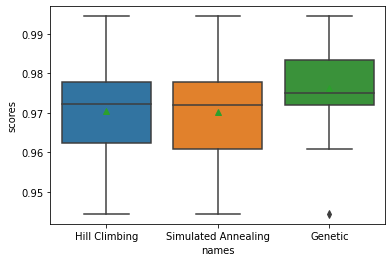

In [21]:
Get_Boxplot(Get_Accuracies(digitsResults), "Digits")

In [20]:
Get_Boxplot(Get_Accuracies(wineResults), "Wine")

NameError: name 'wineResults' is not defined

NameError: name 'files' is not defined

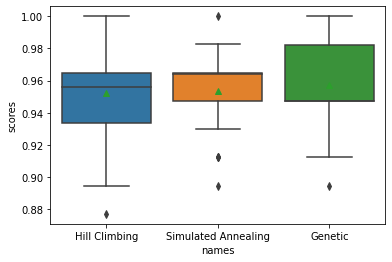

In [ ]:
Get_Boxplot(Get_Accuracies(cancerResults), "Breast Cancer")

# Gerador do T-Student e Wilcoxon

In [22]:
from scipy.stats import ttest_rel, wilcoxon
from tabulate import tabulate

def Print_Tests(newResults):
    result = []

    names = ["Hill Climbing", "Simulated Annealing", "Genetic"]

    for i, primaryResult in enumerate(newResults):
        line = []

        for j, secundaryResult in enumerate(newResults):
            if(i > j):
                _, pTest = ttest_rel(primaryResult[0], secundaryResult[0])
                line.append(names[i] + ' | ' + names[j] + ': {:0.4f}'.format(pTest))
            elif(j > i):
                _, pWilcoxon = wilcoxon(primaryResult[0], secundaryResult[0])
                line.append(names[i] + ' | ' + names[j] + ': {:0.4f}'.format(pWilcoxon))
            else:
                line.append(names[i])

        result.append(line)

    print(tabulate(result))

print("Digits:")
Print_Tests(digitsResults)
print("Wine:")
Print_Tests(wineResults)
print("Cancer:")
Print_Tests(cancerResults)

Digits:
-------------------------------------------  -------------------------------------------  -------------------------------------
Hill Climbing                                Hill Climbing | Simulated Annealing: 0.7725  Hill Climbing | Genetic: 0.0144
Simulated Annealing | Hill Climbing: 0.8829  Simulated Annealing                          Simulated Annealing | Genetic: 0.0022
Genetic | Hill Climbing: 0.0101              Genetic | Simulated Annealing: 0.0028        Genetic
-------------------------------------------  -------------------------------------------  -------------------------------------
